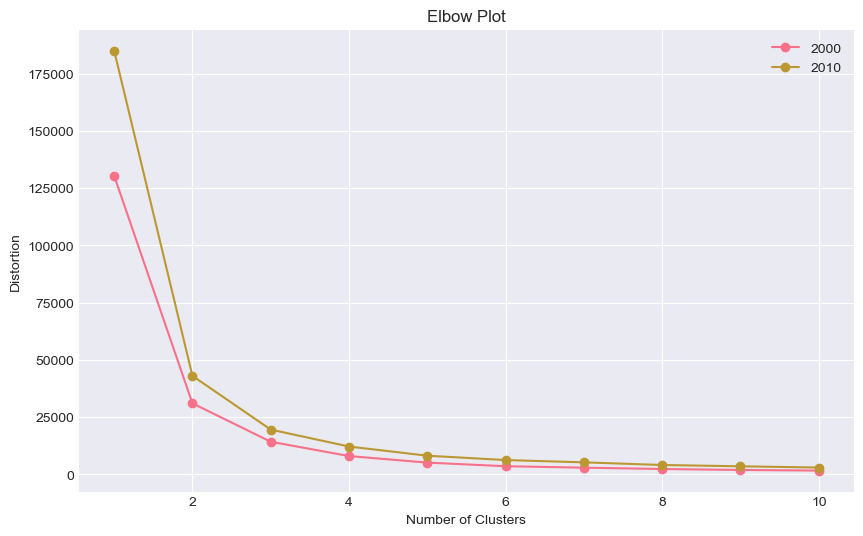

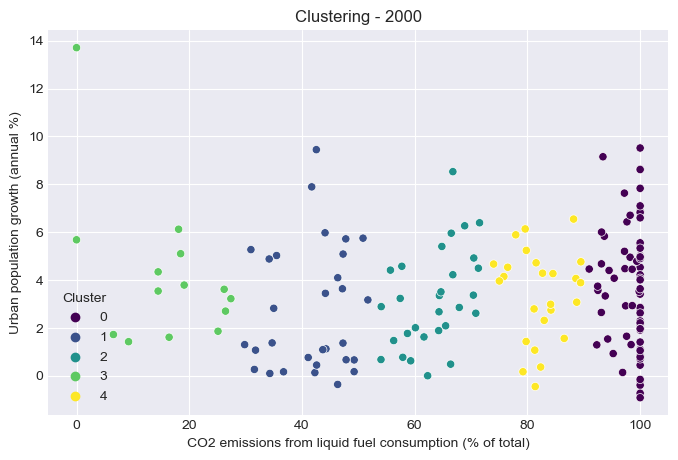

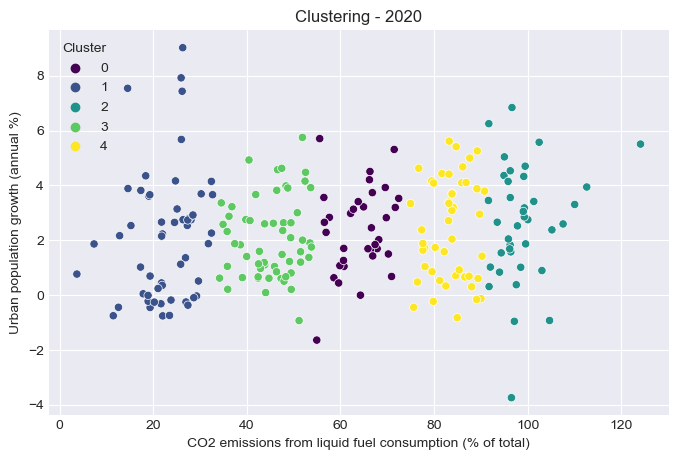

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('API_19_DS2_en_csv_v2_6300757.csv', skiprows=3)
def read_and_filter_data(file_path, indicator1, indicator2, year):
    # Read the data
    df = pd.read_csv(file_path, skiprows=3)

    # Filter data for the specified indicators and year
    data1 = df[df['Indicator Name'] == indicator1][['Country Name', year]].rename(columns={year: indicator1})
    data2 = df[df['Indicator Name'] == indicator2][['Country Name', year]].rename(columns={year: indicator2})

    # Merge dataframes on 'Country Name'
    merged_data = pd.merge(data1, data2, on='Country Name', how='outer').reset_index(drop=True)

    # Drop rows with any NaN values
    filtered_data = merged_data.dropna(how='any').reset_index(drop=True)

    return filtered_data
file_path = 'API_19_DS2_en_csv_v2_6300757.csv'

data_2000 = read_and_filter_data(file_path, 'CO2 emissions from liquid fuel consumption (% of total)', 'Urban population growth (annual %)', '1985' )
data_2020 = read_and_filter_data(file_path, 'CO2 emissions from liquid fuel consumption (% of total)', 'Urban population growth (annual %)', '2005' )
# Function to plot the elbow plot for KMeans clustering
def plot_elbow(data, max_clusters=10, label=''):
    distortions = []

    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)

    # Plot the elbow plot
    plt.plot(range(1, max_clusters + 1), distortions, marker='o', label=label)
    plt.title('Elbow Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')

# Plot elbow plots for both 2000 and 2010 data on the same figure
plt.figure(figsize=(10, 6))
# Extract relevant columns for clustering
columns_for_clustering = ['CO2 emissions from liquid fuel consumption (% of total)', 'Urban population growth (annual %)']


plot_elbow(data_2000[columns_for_clustering], label='2000')
plot_elbow(data_2020[columns_for_clustering], label='2010')

plt.legend()
plt.show()
# Function to perform KMeans clustering and plot the results
def perform_kmeans_clustering(data, n_clusters, label=''):
    # Extract relevant columns for clustering
    columns_for_clustering = ['CO2 emissions from liquid fuel consumption (% of total)', 'Urban population growth (annual %)']

    # Initialize KMeans
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)

    # Fit KMeans to the data
    data['Cluster'] = kmeans.fit_predict(data[columns_for_clustering])

    # Plot the clustered data
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x='CO2 emissions from liquid fuel consumption (% of total)', y='Urban population growth (annual %)',
                    hue='Cluster', palette='viridis', data=data)
    plt.title(f'Clustering - {label}')
    plt.show()

# Define the number of clusters
n_clusters = 5  # You can adjust this based on the elbow plot or your requirements

# Perform KMeans clustering for 2000 data
perform_kmeans_clustering(data_2000, n_clusters, label='2000')

# Perform KMeans clustering for 2010 data
perform_kmeans_clustering(data_2020, n_clusters, label='2020')


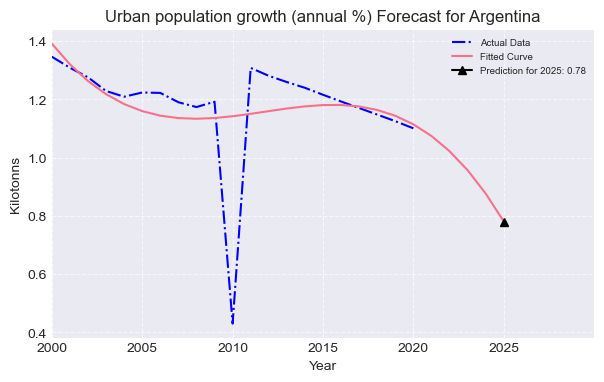

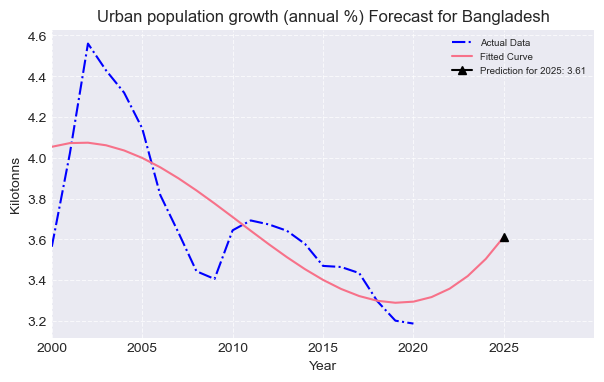

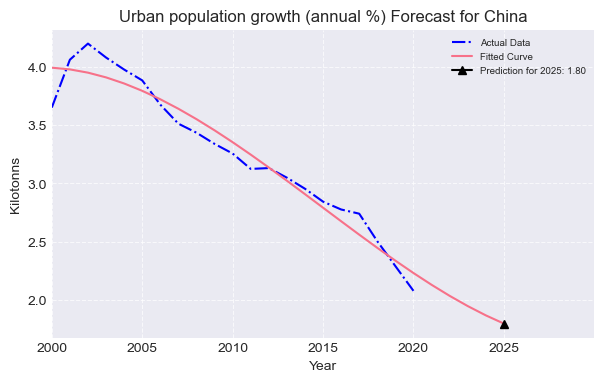

In [132]:
# Set a custom color palette for the plot
sns.set_palette("husl")

# Select three countries and the indicator
selected_countries = ['Argentina', 'Bangladesh', 'China']
indicator_name = 'Urban population growth (annual %)'

# Filter the data
d_s = df[(df['Country Name'].isin(selected_countries)) & (df['Indicator Name'] == indicator_name)].reset_index(drop=True)

# Melt the DataFrame
d_f = d_s.melt(id_vars=['Country Name', 'Indicator Name'], var_name='Year', value_name='Value')

# Filter out non-numeric values in the 'Year' column
d_f = d_f[d_f['Year'].str.isnumeric()]

# Convert 'Year' to integers
d_f['Year'] = d_f['Year'].astype(int)

# Handle NaN values by filling with the mean value
d_f['Value'].fillna(d_f['Value'].mean(), inplace=True)

# Filter data for the years between 1990 and 2020
d_f = d_f[(d_f['Year'] >= 2000) & (d_f['Year'] <= 2020)]

# Create a dictionary to store predictions for each country
predictions = {}

# Extend the range of years to include 2025
all_years_extended = list(range(2000, 2026))

# Create individual line plots for each country with a grid and unique style
for country in selected_countries:
    plt.figure(figsize=(7, 4))
    
    # Plot actual data
    plt.plot(d_f[d_f['Country Name'] == country]['Year'], 
             d_f[data_forecast['Country Name'] == country]['Value'], 
              linestyle='-.', label=f'Actual Data', color='blue')
    
    # Prepare data for the current country
    country_data = d_f[data_forecast['Country Name'] == country]
    X_country = country_data[['Year']]
    y_country = country_data['Value']
    
    # Fit polynomial regression model with degree 3
    degree = 5
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_country)
    
    model = LinearRegression()
    model.fit(X_poly, y_country)
    
    # Predict values for all years (1990 to 2025)
    X_pred = poly_features.transform(pd.DataFrame(all_years_extended, columns=['Year']))
    forecast_values = model.predict(X_pred)
    
    # Store the predictions for the current country
    predictions[country] = forecast_values
    
    # Plot the fitted curve
    plt.plot(all_years_extended, forecast_values, label=f'Fitted Curve', linestyle='-')
    
    # Plot forecast for 2025
    prediction_2025 = forecast_values[-1]
    plt.plot(2025, prediction_2025, marker='^', label=f'Prediction for 2025: {prediction_2025:.2f}', color='black')
    
    plt.title(f'{indicator_name} Forecast for {country}', fontsize=12)
    plt.xlabel('Year', fontsize=10)
    plt.ylabel('Kilotonns', fontsize=10)
    
    # Set x-axis limits and ticks
    plt.xlim(2000, 2030)
    plt.xticks(range(2000, 2030, 5))  # Adjust the step as needed
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.legend(fontsize=7)
    filename = f"{indicator_name}_Forecast_{country.replace(' ', '_')}.png"
    plt.savefig(filename, bbox_inches='tight')
